In [81]:
%pip install -q git+https://github.com/huggingface/transformers.git timm

Note: you may need to restart the kernel to use updated packages.


## Prepare an image using DetrFeatureExtractor

We retrieve an image on which we wish to test the model. Here, we use an image from the validation set of COCO.

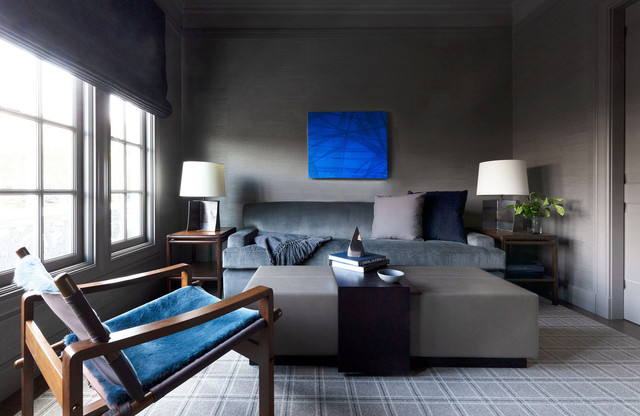

In [82]:
from PIL import Image
import requests

url = "https://i.ibb.co/PwLWCh4/wall.jpg"
im = Image.open(requests.get(url, stream=True).raw)
im

We can prepare the image for the model using `DetrFeatureExtractor`. It will take care of resizing the image + normalization across the channels using the ImageNet mean and standard deviation.

In [83]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")

encoding = feature_extractor(im, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [84]:
encoding['pixel_values'].shape

torch.Size([1, 3, 800, 1230])

## Forward pass

Next, let's run the `pixel_values` through the model.

In [85]:
from transformers import DetrForSegmentation

model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [86]:
outputs = model(**encoding)

This returns a mask for each query (DETR uses 100 queries for COCO).


In [87]:
outputs.pred_masks.shape

torch.Size([1, 100, 200, 308])

Let us visualize the high confidence ones:

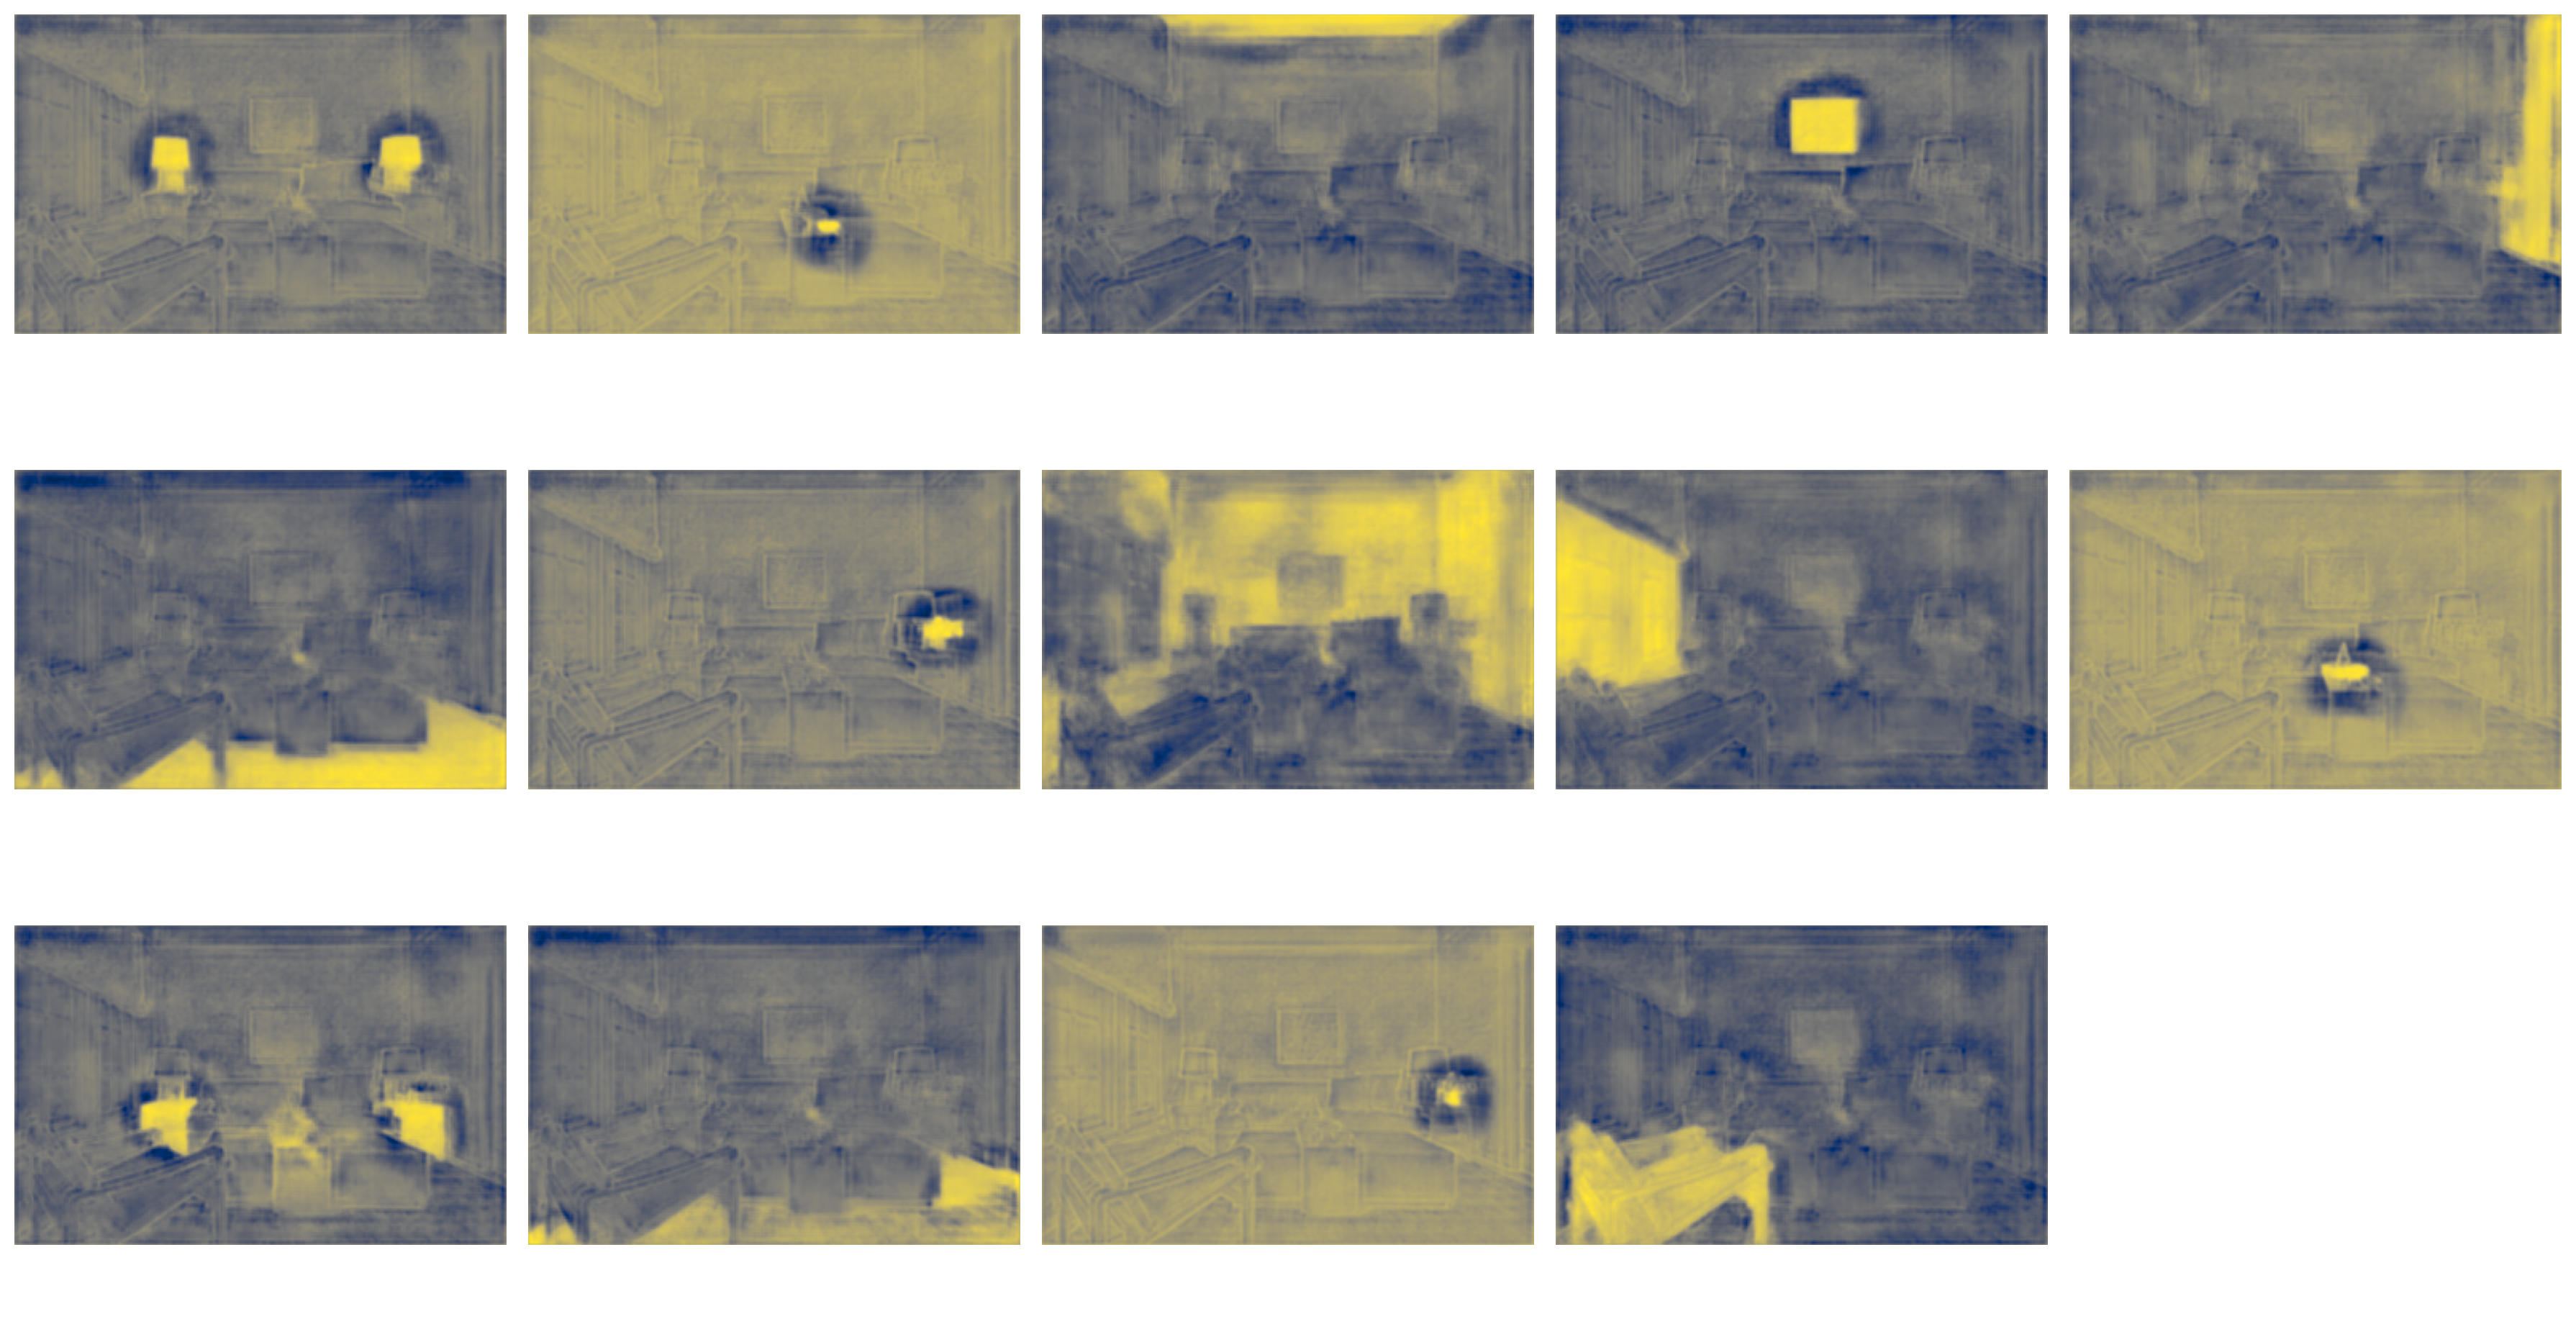

In [88]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import math

# compute the scores, excluding the "no-object" class (the last one)
scores = outputs.logits.softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

# Plot all the remaining masks
ncols = 5
fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(keep.sum().item() / ncols), figsize=(18, 10))
for line in axs:
    for a in line:
        a.axis('off')
for i, mask in enumerate(outputs.pred_masks[keep].detach().numpy()):
    ax = axs[i // ncols, i % ncols]
    ax.imshow(mask, cmap="cividis")
    ax.axis('off')
fig.tight_layout()

Finally, we can merge the masks using a pixel-wise argmax, to obtain a unified panoptic segmentation of the image. To do that, we can use `DetrFeatureExtractor`'s `post_process_panoptic` method.

In [89]:
import torch

# use the post_process_panoptic method of DetrFeatureExtractor, which expects as input the target size of the predictions
# (which we set here to the image size)
processed_sizes = torch.as_tensor(encoding['pixel_values'].shape[-2:]).unsqueeze(0)
result = feature_extractor.post_process_panoptic(outputs, processed_sizes)[0]

Let's visualize the result!

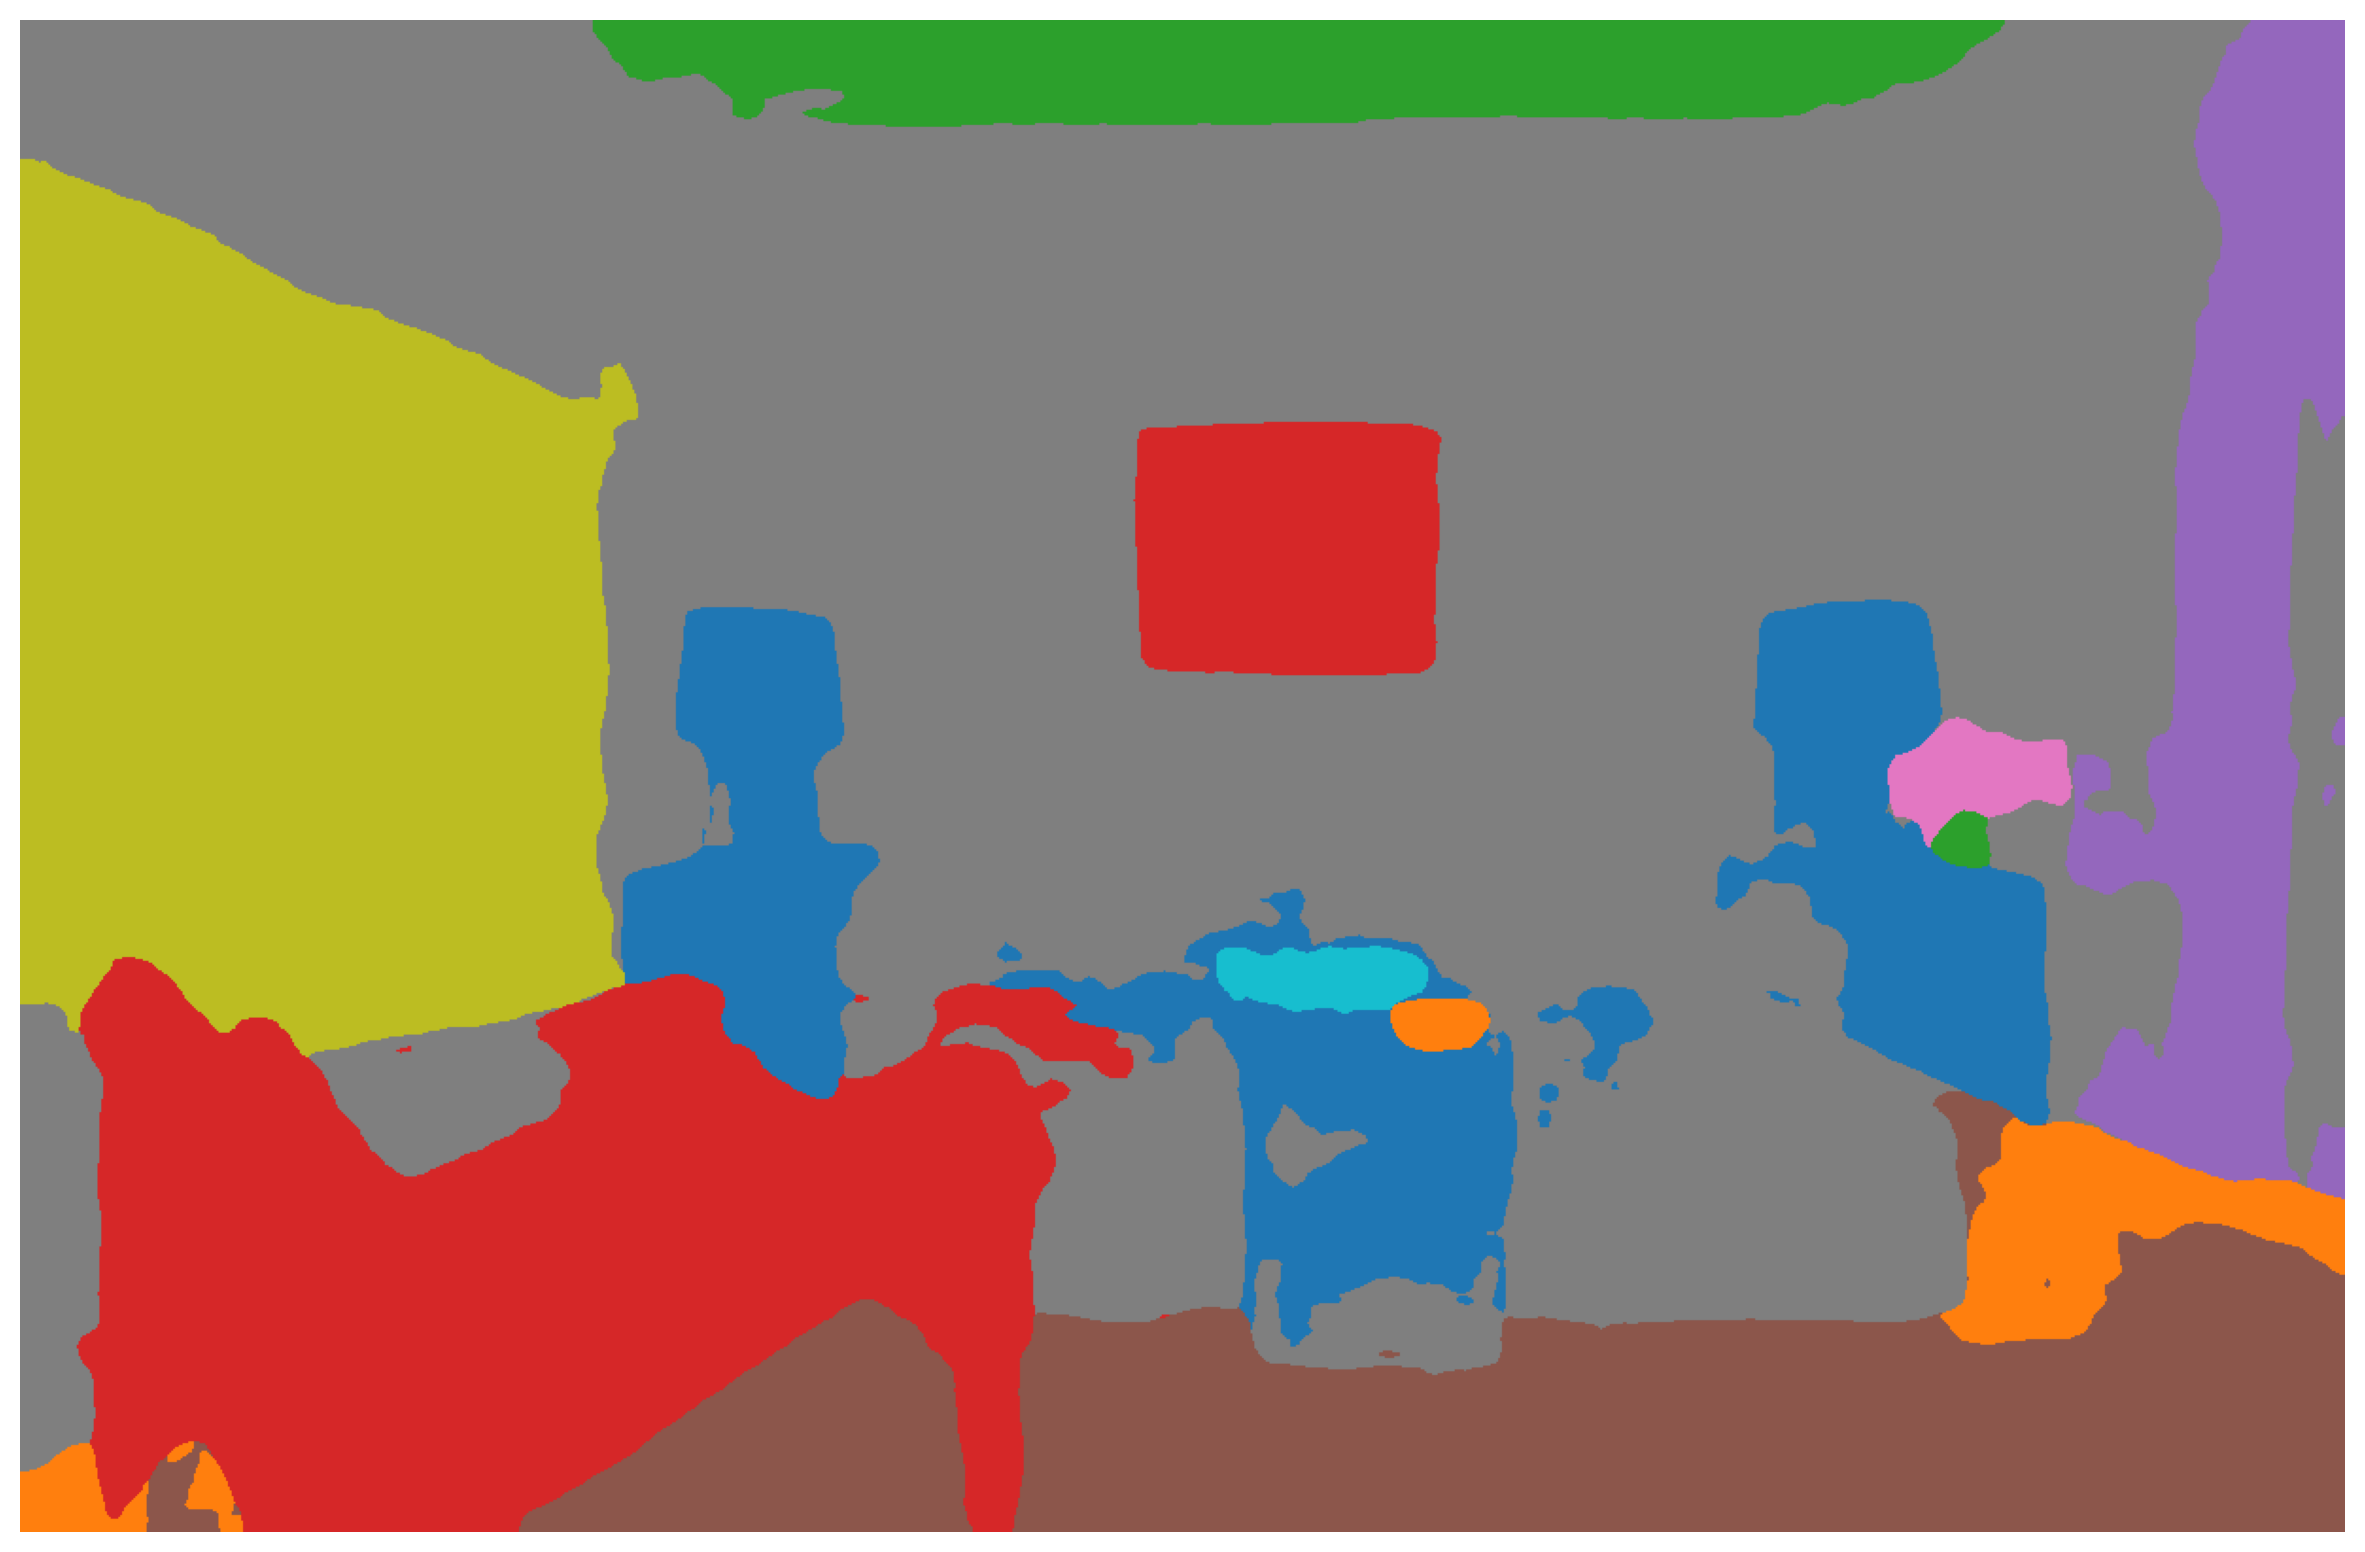

In [90]:
import itertools
import io
import seaborn as sns
import numpy
from transformers.image_transforms import rgb_to_id, id_to_rgb

palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb_to_id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

## Visualization using Detectron2

Facebook AI's [Detectron2](https://github.com/facebookresearch/detectron2) package has a nice visualizer which visualizes the panoptic segmentation in a (if you ask me) more beautiful way. Let's install it, and use it.

Note: when you run the cell below, it might give an error related to the PyYAML package. Clicking "restart runtime and run all" above (under "Runtime") resolves this issue.

In [93]:
!git clone https://github.com/facebookresearch/detectron2.git
!pip install ./detectron2
!pip install --upgrade pyyaml

fatal: destination path 'detectron2' already exists and is not an empty directory.
Processing ./detectron2
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/Users/prince/Desktop/push/segment_anything/detectron2/setup.py", line 10, in <module>
          import torch
      ModuleNotFoundError: No module named 'torch'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [92]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

ModuleNotFoundError: No module named 'detectron2.utils'

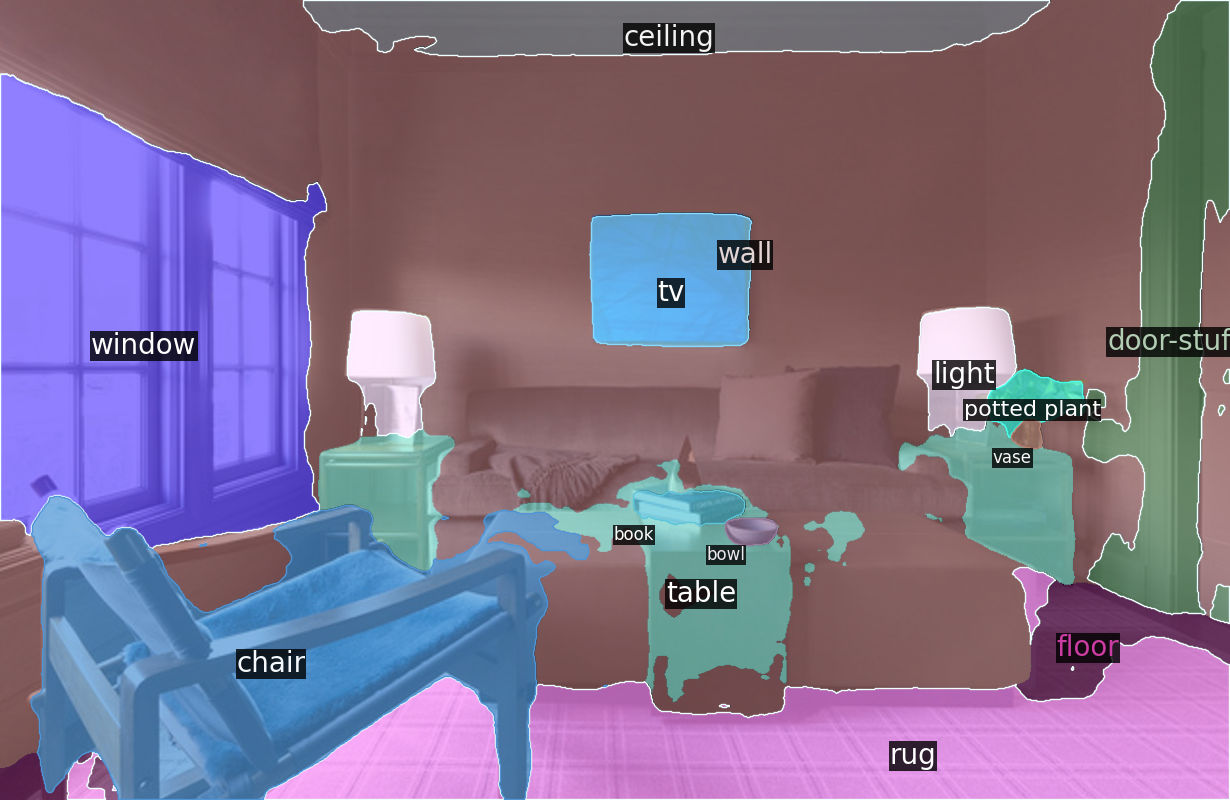

In [ ]:
from copy import deepcopy

# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb_to_id(panoptic_seg))

# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]

# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
cv2_imshow(v.get_image())

In [ ]:
print(segments_info)

[{'id': 0, 'isthing': False, 'category_id': 13, 'area': 18416.0}, {'id': 1, 'isthing': True, 'category_id': 45, 'area': 1231.0}, {'id': 2, 'isthing': False, 'category_id': 39, 'area': 35719.0}, {'id': 3, 'isthing': True, 'category_id': 62, 'area': 20844.0}, {'id': 4, 'isthing': False, 'category_id': 7, 'area': 46049.0}, {'id': 5, 'isthing': False, 'category_id': 53, 'area': 99734.0}, {'id': 6, 'isthing': True, 'category_id': 58, 'area': 3950.0}, {'id': 7, 'isthing': False, 'category_id': 52, 'area': 458666.0}, {'id': 8, 'isthing': False, 'category_id': 36, 'area': 120275.0}, {'id': 9, 'isthing': True, 'category_id': 73, 'area': 3198.0}, {'id': 10, 'isthing': False, 'category_id': 42, 'area': 51909.0}, {'id': 11, 'isthing': False, 'category_id': 43, 'area': 15285.0}, {'id': 12, 'isthing': True, 'category_id': 75, 'area': 716.0}, {'id': 13, 'isthing': True, 'category_id': 56, 'area': 108008.0}]
